# Discrete Fourier Transform

The discrete Fourier Transform (DFT) consists in applying an Fourier transform (FT) to a serie of number $x_{n}$ instead of a continuous signal $x(t)$. This relies on rectangle approximation of function integration. This notebook proposes to remain the basic definitions of usual Fourier transforms and naturally introduce the DSF. An example is then given using different implementation of the FT.

## Basic definitions

### Fourier transform of a continuous signal

A signal $x(t)$ can be decomposed as a infinite sum of periodic functions $e^{i\omega}t$. The weight of each of these function, $X(\omega)$, is called the fourier transform of $x(t)$. The inverse transformation is also possible and represents a way to determine $X(\omega)$ knowing $x(t)$:
$$
x(t) = \int^{+\infty}_{-\infty} X(\omega) \, e^{i\omega t}\text{d}\omega
$$

$$
X(\omega) = \int^{-\infty}_{-\infty} x(t) \, e^{-i\omega t}\text{d}t
$$

The auto-correlation function $R(\tau)$ of a signal $x(t)$ probes how a change of $x(t_0)$ can impact $x(t_0+\tau)$. It is a way to assess the memory time of the signal, or its temporal correlation. It is defined as:
$$
 R(\tau) \equiv \int^{+\infty}_{-\infty} x(t)\,\overline{x}(t-\tau)\text{d}\tau
$$

### Discrete fourier transform

We know that integral of function can be approximated by a Riemann sum. The sampling time is called $T_s$ and the number of considered point is $N$.
$$
X(\omega) \;=\; \int^{-\infty}_{-\infty} x(t) \, e^{-i\omega t}\text{d}t \;\approx \;  \sum^{N-1}_{n=0} \; x(nT_{s}) \: e^{-i\omega \, n T_{s}} \: T_{s}
$$

By introducing the sampling frequency $\omega_{s} \equiv 2\pi/T_{s}$, and the discrete frequency values ${\omega_{k}} = {k \frac{\omega_{s}}{N}}$, we can reformulate things as:
$$
 X(\omega_{k}) \equiv X_{k} \; = \; T_{s} \; \sum^{N-1}_{n=0} \; x(nT_{s}) \: e^{-i \, 2\pi \, \frac{kn}{N} }
$$

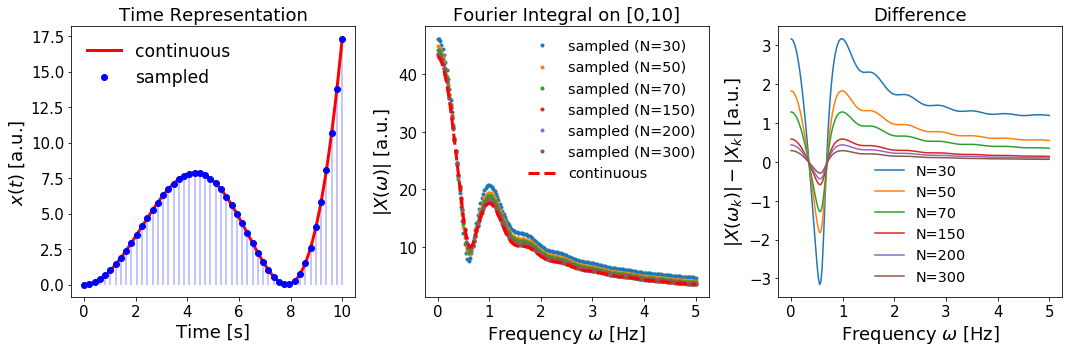

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.integrate   as integrate

%matplotlib inline

title_fsize=18
ticks_fsize=15

def signal(t):
    return t**2 *np.cos(0.2*t )**2

T  = np.linspace(0,10,5000)
Ts = np.linspace(0,10,50)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Time Representation', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.ylabel('$x(t)$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.plot(T ,signal(T) ,'r-', linewidth='3', label='continuous')
plt.plot(Ts,signal(Ts),'bo', label='sampled')
for t in Ts: plt.vlines(t,  0, signal(t), color='blue', alpha=0.3 )
plt.legend(frameon=False, fontsize='xx-large' ,loc='best')


# Compare "continuous" integral and Riemann sum on [0,10] interval
def FTsignal(w):
    realI = integrate.quad(lambda t: signal(t)*np.cos(w*t), 0,10)
    ImgI  = integrate.quad(lambda t: signal(t)*np.sin(w*t), 0,10)
    Xw = realI[0] + 1j*ImgI[0]
    return Xw

def DFTsignal(w,Ns):
    ts = np.linspace(0,10,Ns)
    dt = ts[1]-ts[0]
    return np.sum( signal(ts)*np.exp( -1j*w*ts ) ) * dt

# Vectorize is needed to extend the function 
# to arrays: array_out = f(array_in)
FTsignal_vec  = np.vectorize( FTsignal  )
DFTsignal_vec = np.vectorize( DFTsignal )

W    = np.linspace(0,5,200)                                   # Freqency scan
Npts = [30,50,70,150,200,300]                                 # N sampling scan
CFT  = np.absolute(FTsignal_vec(W))                           # Continuous FT
DTF  = [ [n,np.absolute(DFTsignal_vec(W,n))] for n in Npts ]  # List of DFT over N sampling: [N, DFT(N)]

plt.subplot(132)
plt.title('Fourier Integral on [0,10]', fontsize=title_fsize)
plt.xlabel('Frequency $\omega$ [Hz]', fontsize=title_fsize)
plt.ylabel('$|X(\omega)|$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
for dft in DTF: plt.plot( W, dft[1], 'o', markersize=3, label='sampled (N={:.0f})'.format(dft[0]) )
plt.plot( W, CFT, 'r--' ,label='continuous', linewidth=3 )
plt.legend(frameon=False, fontsize='x-large', loc='best')

plt.subplot(133)
plt.title('Difference', fontsize=title_fsize)
plt.xlabel('Frequency $\omega$ [Hz]', fontsize=title_fsize)
plt.ylabel('$|X(\omega_k)|-|X_k|$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
for dft in DTF: plt.plot( W, dft[1]-CFT, label='N={:.0f}'.format(dft[0]))
plt.legend(frameon=False, fontsize='x-large', loc='best')
plt.tight_layout()

At the end, the DFT can be defined for any set of points $\{x_n\}$ and will be proportional to the continuous Fourier transform, if simply defined as
$$
 x_{n} = \sum^{N-1}_{k=0} \; X_k \: e^{i \, 2\pi \, \frac{kn}{N} }
$$

$$
 X_{k} = \sum^{N-1}_{n=0} \; x_n \: e^{-i \, 2\pi \, \frac{kn}{N} }
$$

The interest of the DFT is a fast alorithm which exploits the internal structure of the FT in order to reduce the number of operations with respect to the direct definition application. However, there are some bias introduced by the discretization of the signal $x(t)$. The first one is the multiplication of the spectrum. Indeed, the discretisation can be put in equation using a product with a sum of Dirac function:
$$
 x_{\text{sampled}} = x(t) \times \sum^{N-1}_{n=0} \delta(t-nT_{s})
$$

This products becomes a convolution in Fourier space, meaning that the spectrum will be duplicated every $1/T_s$. It means that the maximum frequency of the signal $f_{\text{max}}$ should verify
$$
2 \times f_{\text{max}} < \frac{1}{T_{s}}
$$
This is the Shanon criteria: a signal must be sampled at least twice faster than its maximum frequency in order to keep all the information.

## Concrete numerical example


### Signal
We can define a real signal $x(t)$ to be analyzed by
$$
 x(t) \;=\; (\, \cos(2\pi ft) + \delta x \,) \; E(t)
$$
where $\delta x$ is a noise term and $E(t)$ a slow function playing the role of an envelopp.

In [2]:
# Define a signal including periodic component, noise and an enveloppe
Npx      = 10000
dT       = 200
time     = np.linspace(-dT/2,dT/2,Npx)
x_period = np.cos(3*2*np.pi*time)
x_noise  = np.random.uniform(0,0.2,Npx)
x_envlop = np.exp( - (np.abs(time)/2)**2 ) + 0.3*np.exp( - (np.abs(time-5)/2)**2 ) \
    + 0.3* np.exp( - (np.abs(time+5)/2)**2 )

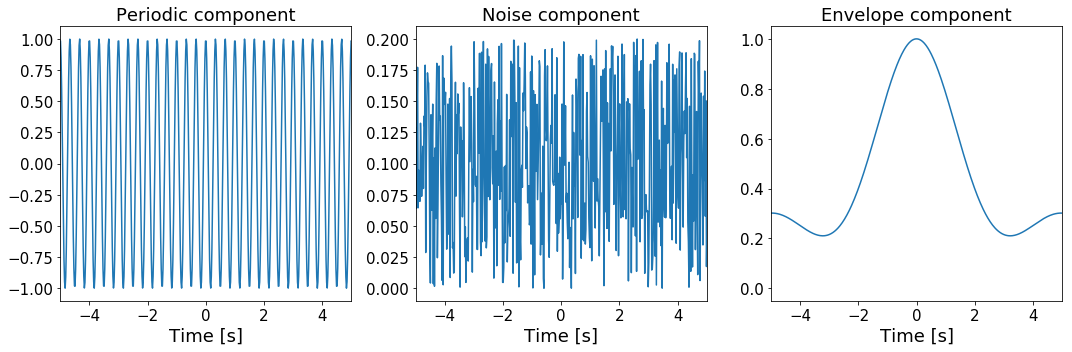

In [3]:
# Plot each signal component
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Periodic component', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(-5,5)
plt.plot(time,x_period)
plt.subplot(132)
plt.title('Noise component', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(-5,5)
plt.plot(time,x_noise)
plt.subplot(133)
plt.title('Envelope component', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(-5,5)
plt.plot(time,x_envlop)
plt.tight_layout()

In [4]:
# Define the full signal and it's auto-correlation function
signal   = (x_period+x_noise) * x_envlop
autocorr = np.correlate(signal,signal,'same')

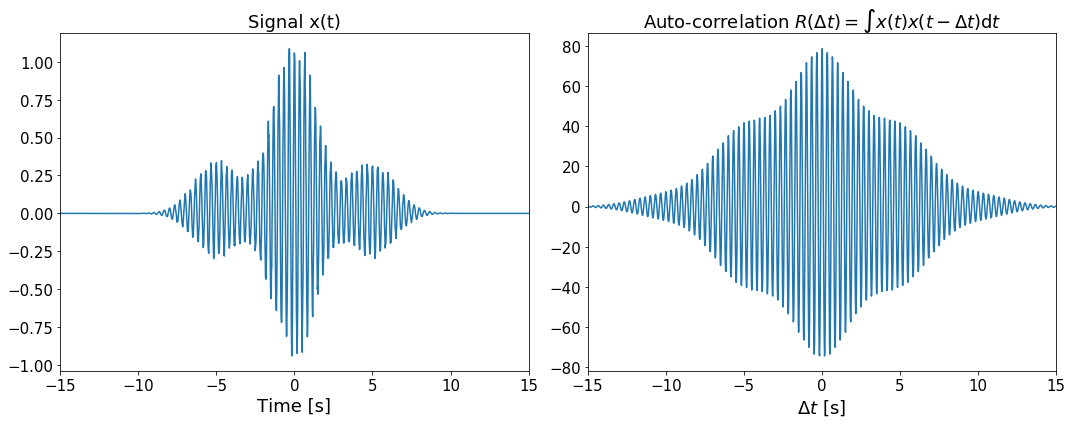

In [5]:
# Plot them
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Signal x(t)', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(-15,15)
plt.plot(time,signal)
plt.subplot(122)
plt.title('Auto-correlation $R(\Delta t) = \int x(t)x(t-\Delta t)\mathrm{d}t$', fontsize=title_fsize)
plt.xlabel('$\Delta t$ [s]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(-15,15)
plt.plot(time,autocorr)
plt.tight_layout()

In [6]:
# Compute the FFT of x(t) and R(tau)
import scipy.fftpack as ft
x_rfft          = ft.rfft(signal)
Corr_rfft       = ft.rfft(autocorr)
rfreq           = ft.rfftfreq(signal.size, d=time[1]-time[0])
x_rfft_norm     = x_rfft    / np.sqrt( len(x_rfft) )
Corr_rfft_norm  = Corr_rfft / np.sqrt(len(Corr_rfft))

### Real FFT function
The fftr function considers only real signals $\text{Im}[x(t)]=0$ and will have only positive frequencies. Indeed, if the input signal is a real function, then we have the following properties:
$$
 \text{Re}[X_{-k}] = \text{Re}[X_{k}] 
$$
$$
 \text{Im}[X_{-k}] = - \text{Im}[X_{k}] 
$$
This means that the positive and negatives frequencies carrie the same information.


### Correct normalization

Also, the normalisation has to be properly computed since the FFT is not correcly normalized by default. The scale factor to be applied is $1/\sqrt{N}$ so that $X_{k}$ and $x_{n}$ contains the same quantitative information. Concretely, it means that applying FFT to $X_k$ gives back $x_n$. In the current implementation of the real FFT, a factor 1/N is applied to the inverse FFT so that $\text{FFT}^{-1}(\text{FFT}[x]) = x$.

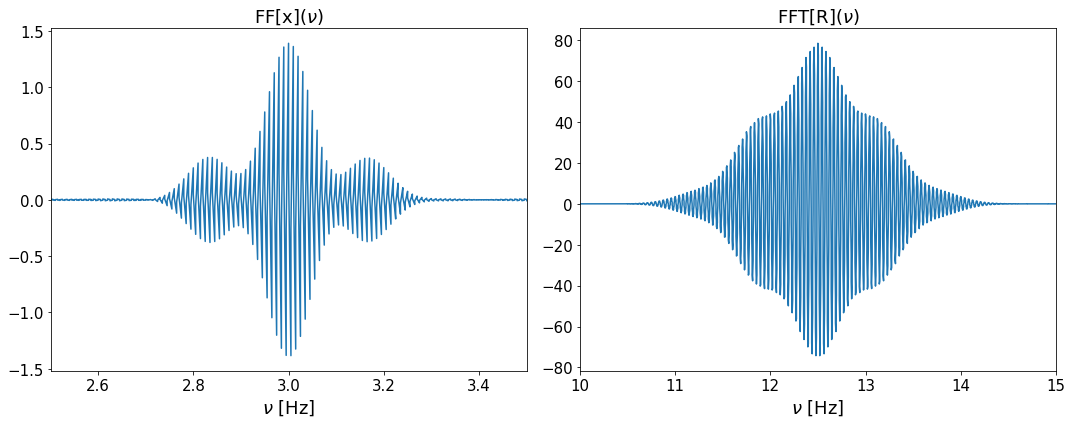

In [7]:
# Plot these two functions
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('FF[x]($\\nu$)', fontsize=title_fsize)
plt.xlabel('$\\nu$ [Hz]' , fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(2.5,3.5)
plt.plot(rfreq,x_rfft_norm)
plt.subplot(122)
plt.title('FFT[R]($\\nu$)', fontsize=title_fsize)
plt.xlabel('$\\nu$ [Hz]'  , fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.xlim(10,15)
plt.plot(rfreq,autocorr)
plt.tight_layout()

### Energy in time and frequency representations

One can very that the energy computed in the Fourier representation is the same than the one in the time representation (Parseval theorem):
$$
 \int^{\infty}_{-\infty} |x(t)|^2 \mathrm{d}t \;=\;  \int^{\infty}_{-\infty} |X(\omega)|^2 \mathrm{d}\omega
$$
This equations can be easily interpreted in term of scalar product in the function space. Whatever the chosen base $\{x(t)\}$ or $\{X(\omega)\}$, the scalar product $<x,x>$ is identical.

In [8]:
EnergyT = np.sum( signal*signal.conj() )
EnergyF = ( x_rfft_norm[0]*x_rfft_norm[0].conj() + 2 * np.sum(x_rfft_norm[1:]*x_rfft_norm[1:].conj()) )
print( 'E[time] = {:.2f}'.format(EnergyT) )
print( 'E[freq] = {:.2f}'.format(EnergyF) )

E[time] = 78.52
E[freq] = 78.52


Since we used the real FFT function, one has to be a bit careful in the calculation of the energy in the frequency space. Basically, each component has to be multiply by 2 (since both negative and positive frequencies have to be included), except the $f=0$ component which doesn't have negative counter part.

Using the normal FFT, there is nothing to do other than normalizing it properly by a factor $1/\sqrt{N}$ and sum up the modulus of the values, as demonstrated below (the result is in principle complex but ends up to be pure real, as expected).

In [9]:
# Using normal fft
x_fft      = ft.fft(signal)
x_fft_norm = x_fft    / np.sqrt( len(x_fft) )
EnergyF    = np.sum( x_fft_norm*x_fft_norm.conj() )
print( 'E[time] = {:.2f}'.format(EnergyT) )
print( 'E[freq] = {:.2f}'.format(EnergyF) )

E[time] = 78.52
E[freq] = 78.52+0.00j


### Signal filtering in Fourier space

It is possible to remove or attenuate some frequencies in order to shape our time signal. The idea is to apply a transfert function $H(\omega)$ which encodes the response of a linear system and transform back to time representation:
$$
X_{\text{out}}(\omega) \;=\; H(\omega) \: X_{\text{in}}(\omega)
$$
$$
x_{\text{out}}(t) = \text{FFT}^{-1}(X_{\text{out}}) \;=\; \int^{\infty}_{-\infty} X_{\text{out}}(\omega) \, e^{i\omega t}\text{d}\omega
$$

Below, we try to simulate the response of a linear system by the following transfer function:
$$
H(\omega) \; = \; e^{-\omega} \: \times \: \left( 1 - \frac{a}{(\omega-\omega_0)^2 + a} \right)
$$

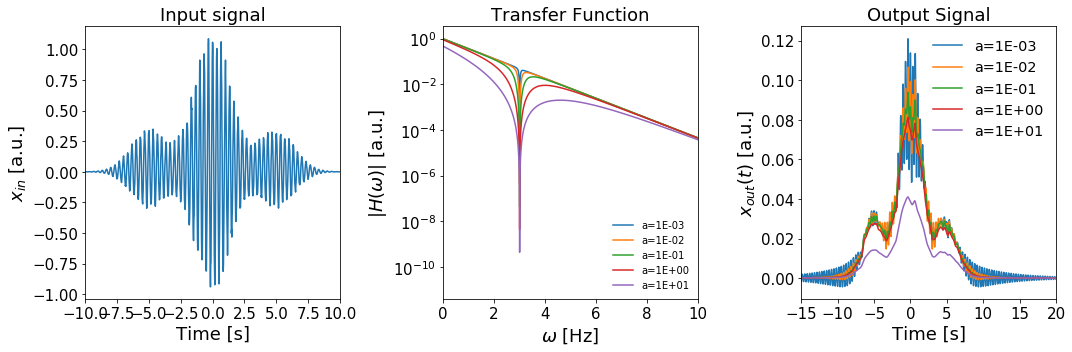

In [10]:
# Transfert function
def TransfertFunction(w,a):
    CutBand = 1 - a/( (w-3)**2 + a )
    PassLow = np.exp(-w)
    return CutBand*PassLow

# Needed to make the function compatible with np.arrays
FilterFunc = np.vectorize(TransfertFunction) 

# Filtered signal in the frequency space and inverse FFT
Xk_filter = x_rfft.copy()
a_array = [0.001,0.01,0.1,1,10]
x_filter_array = [ [a,ft.irfft(Xk_filter * FilterFunc(rfreq,a))] for a in a_array]

# Plotting
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Input signal', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.ylabel('$x_{in}}(t)$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
plt.plot(time,signal)
plt.xlim(-10,10)

plt.subplot(132)
plt.title('Transfer Function', fontsize=title_fsize)
plt.xlabel('$\omega$ [Hz]', fontsize=title_fsize)
plt.ylabel('$|H(\omega)|$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
for a in a_array: plt.plot(rfreq, FilterFunc(rfreq,a), label='a={:.0E}'.format(a))
plt.xlim(0,10)
plt.semilogy()
plt.legend(frameon=False,loc='best')

plt.subplot(133)
plt.title('Output Signal', fontsize=title_fsize)
plt.xlabel('Time [s]', fontsize=title_fsize)
plt.ylabel('$x_{out}(t)$ [a.u.]', fontsize=title_fsize)
plt.xticks(fontsize=ticks_fsize); plt.yticks(fontsize=ticks_fsize)
for xf in x_filter_array: plt.plot(time, xf[1], label='a={:.0E}'.format(xf[0]))
plt.xlim(-15,20)
plt.legend(frameon=False,loc='best',fontsize='x-large')

plt.tight_layout()